In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/databersih.csv')
data.head()


,requirementtext,class_encoded
0,the system shall refresh the display every 60 ...,1
1,if projected the data must be readable on a 10...,3
2,if projected the data must be understandable o...,3
3,the product shall ensure that it can only be a...,2
4,the product shall be intuitive and selfexplana...,3


In [ ]:
data.head(741)

,requirementtext,class_encoded
0,the system shall refresh the display every 60 ...,1
1,if projected the data must be readable on a 10...,3
2,if projected the data must be understandable o...,3
3,the product shall ensure that it can only be a...,2
4,the product shall be intuitive and selfexplana...,3
...,...,...
736,the rfs system should be able to easily interf...,0
737,only authorized user shall access the rfs syst...,2
738,user access should be limited to the permissio...,2
739,the users should be able to easily use the sys...,3


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 741 entries, 0 to 740
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   requirementtext  741 non-null    object
 1   class_encoded    741 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.7+ KB


In [ ]:
# Check for duplicate rows
duplicate_rows = data.duplicated()

# Count duplicates
num_duplicates = duplicate_rows.sum()

# Show duplicates if any
duplicates = data[duplicate_rows]

num_duplicates, duplicates


(167,
                                        requirementtext  class_encoded
 314  if a user account is revoked it can only be re...              2
 318  the product must support internet explorer 55 ...              0
 319  the product must support mozilla firefox 10 an...              0
 344  the product must work with most database manag...              0
 404  the website will use standard internet convent...              3
 ..                                                 ...            ...
 730  the application shall be able to complete ever...              1
 731  the application shall run on a web application...              0
 732  a primary database will be used to store cache...              0
 733  a secondary database will be used to store his...              0
 737  only authorized user shall access the rfs syst...              2
 
 [167 rows x 2 columns])

In [ ]:
# Remove duplicate rows
data_no_duplicates = data.drop_duplicates()

# Check the number of rows after removing duplicates
rows_after_removal = data_no_duplicates.shape[0]

rows_after_removal

574

In [ ]:
# Rename the cleaned dataset variable
data = data_no_duplicates

# Display the first few rows of the renamed dataset
data.head()

,requirementtext,class_encoded
0,the system shall refresh the display every 60 ...,1
1,if projected the data must be readable on a 10...,3
2,if projected the data must be understandable o...,3
3,the product shall ensure that it can only be a...,2
4,the product shall be intuitive and selfexplana...,3


In [ ]:
# prompt: Menggunakan data DataFrame: liat jumlah masing masing kellas di class_encoded

# Calculate the count of each class in the 'class_encoded' column
class_counts = data['class_encoded'].value_counts()

# Print the class counts
class_counts


,count
class_encoded,
3,162
2,154
0,130
1,128


In [ ]:
!pip install transformers torch

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel

# Load BERT tokenizer dan model (bert-large-uncased)
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")
model = BertModel.from_pretrained("bert-large-uncased")

# Fungsi untuk mendapatkan embedding BERT-Large
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0)
    return cls_embedding.numpy()

# Generate BERT embedding
print("Menghasilkan embedding BERT-Large...")
data['bert_embedding'] = data['requirementtext'].apply(lambda x: get_bert_embedding(x))

# Cek hasil embedding untuk satu data
print("Hasil embedding untuk satu data:")
print(data['bert_embedding'].iloc[0])

# Konversi data ke Tensor
X = torch.tensor(data['bert_embedding'].tolist(), dtype=torch.float32)
y = torch.tensor(data['class_encoded'].tolist(), dtype=torch.long)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Menghasilkan embedding BERT-Large...
Hasil embedding untuk satu data:
[-0.4645768  -0.4386072  -0.4196976  ... -0.34623814 -0.6930312
  0.23217355]


<ipython-input-8-4f3eb0c1e6eb>:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X = torch.tensor(data['bert_embedding'].tolist(), dtype=torch.float32)


In [ ]:
import torch.nn as nn
import torch.optim as optim

# RBM Class
class RBM(nn.Module):
    def __init__(self, visible_dim, hidden_dim):
        super(RBM, self).__init__()
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        self.W = nn.Parameter(torch.randn(hidden_dim, visible_dim) * 0.1)
        self.h_bias = nn.Parameter(torch.zeros(hidden_dim))
        self.v_bias = nn.Parameter(torch.zeros(visible_dim))

    def sample_hidden(self, v):
        h_prob = torch.sigmoid(torch.matmul(v, self.W.t()) + self.h_bias)
        return h_prob, torch.bernoulli(h_prob)

    def sample_visible(self, h):
        v_prob = torch.sigmoid(torch.matmul(h, self.W) + self.v_bias)
        return v_prob, torch.bernoulli(v_prob)

    def forward(self, v):
        _, h = self.sample_hidden(v)
        return h

# DBN Class
class DBN(nn.Module):
    def __init__(self, layers):
        super(DBN, self).__init__()
        self.rbms = nn.ModuleList([
            RBM(layers[i], layers[i + 1]) for i in range(len(layers) - 1)
        ])

    def forward(self, x):
        for rbm in self.rbms:
            x, _ = rbm.sample_hidden(x)
        return x

# DBN Classifier with Dropout
class DBNClassifier(nn.Module):
    def __init__(self, dbn, output_dim, dropout_rate=0.5):
        super(DBNClassifier, self).__init__()
        self.dbn = dbn
        self.dropout = nn.Dropout(p=dropout_rate)  # Dropout Layer
        self.classifier = nn.Linear(dbn.rbms[-1].hidden_dim, output_dim)

    def forward(self, x):
        x = self.dbn(x)
        x = self.dropout(x)  # Apply Dropout
        x = self.classifier(x)
        return x

# Training RBM
def train_rbm(rbm, data, epochs, batch_size, learning_rate):
    optimizer = optim.SGD(rbm.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        for i in range(0, len(data), batch_size):
            batch = data[i:i + batch_size]
            batch = torch.tensor(batch, dtype=torch.float32)
            v_prob, v_sample = rbm.sample_visible(rbm.sample_hidden(batch)[1])
            loss = criterion(v_prob, batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# Training DBN
def train_dbn(dbn, data, epochs_per_rbm, batch_size, learning_rate):
    input_data = data
    for rbm in dbn.rbms:
        train_rbm(rbm, input_data, epochs_per_rbm, batch_size=batch_size, learning_rate=learning_rate)
        input_data = rbm.forward(torch.tensor(input_data, dtype=torch.float32)).detach().numpy()


In [ ]:
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.7 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [ ]:
# Bayesian Optimization Function
def objective(trial):
    # Sample hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 128)
    epoch = trial.suggest_int('epoch', 5, 50)
    epoch_per_rbm = trial.suggest_int('epoch_per_rbm', 5, 50)

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_accuracies = []

    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Train DBN model
        dbn = DBN([X.shape[1], 128, 64])
        classifier = DBNClassifier(dbn, output_dim=len(torch.unique(y)), dropout_rate=0.5)
        train_dbn(dbn, X_train.numpy(), epochs_per_rbm=epoch_per_rbm, batch_size=batch_size, learning_rate=lr)

        classifier.train()
        optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)
        for _ in range(epoch):
            for i in range(0, len(X_train), batch_size):
                batch_X = X_train[i:i + batch_size]
                batch_y = y_train[i:i + batch_size]
                optimizer.zero_grad()
                outputs = classifier(batch_X)
                loss = torch.nn.CrossEntropyLoss()(outputs, batch_y)
                loss.backward()
                optimizer.step()

        # Evaluate
        classifier.eval()
        with torch.no_grad():
            y_val_pred = torch.argmax(classifier(X_val), dim=1)
            accuracy = accuracy_score(y_val.numpy(), y_val_pred.numpy())
            fold_accuracies.append(accuracy)

    return sum(fold_accuracies) / len(fold_accuracies)

# Run Bayesian Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2025-01-05 05:37:00,262] A new study created in memory with name: no-name-ed044635-2ecf-4ed8-8827-49717992723c
[I 2025-01-05 05:37:30,106] Trial 0 finished with value: 0.5677858439201453 and parameters: {'lr': 0.015410783645345056, 'batch_size': 17, 'epoch': 50, 'epoch_per_rbm': 15}. Best is trial 0 with value: 0.5677858439201453.
[I 2025-01-05 05:37:43,952] Trial 1 finished with value: 0.9252268602540834 and parameters: {'lr': 0.0035531332598476087, 'batch_size': 94, 'epoch': 18, 'epoch_per_rbm': 47}. Best is trial 1 with value: 0.9252268602540834.
[I 2025-01-05 05:37:50,850] Trial 2 finished with value: 0.26826981246218995 and parameters: {'lr': 1.220941088029544e-05, 'batch_size': 102, 'epoch': 43, 'epoch_per_rbm': 7}. Best is trial 1 with value: 0.9252268602540834.
[I 2025-01-05 05:38:03,098] Trial 3 finished with value: 0.2945553539019964 and parameters: {'lr': 0.06348430502053946, 'batch_size': 115, 'epoch': 19, 'epoch_per_rbm': 45}. Best is trial 1 with value: 0.9252268602540

Hyperparameter Optimal: {'lr': 0.005873733779590871, 'batch_size': 111, 'epoch': 19, 'epoch_per_rbm': 19}
Processing Fold 1...
Fold 1 Accuracy: 0.9138
Processing Fold 2...
Fold 2 Accuracy: 0.9310
Processing Fold 3...
Fold 3 Accuracy: 0.9483
Processing Fold 4...
Fold 4 Accuracy: 0.9310
Processing Fold 5...
Fold 5 Accuracy: 0.9649
Processing Fold 6...
Fold 6 Accuracy: 0.8947
Processing Fold 7...
Fold 7 Accuracy: 0.9298
Processing Fold 8...
Fold 8 Accuracy: 0.9649
Processing Fold 9...
Fold 9 Accuracy: 0.9298
Processing Fold 10...
Fold 10 Accuracy: 0.9825

Rata-rata Akurasi Cross-Validation: 0.9391

Classification Report (All Folds):
              precision    recall  f1-score   support

           O       0.93      0.92      0.93       130
          PE       0.92      0.91      0.92       128
          SE       0.95      0.97      0.96       154
          US       0.95      0.94      0.94       162

    accuracy                           0.94       574
   macro avg       0.94      0.94   

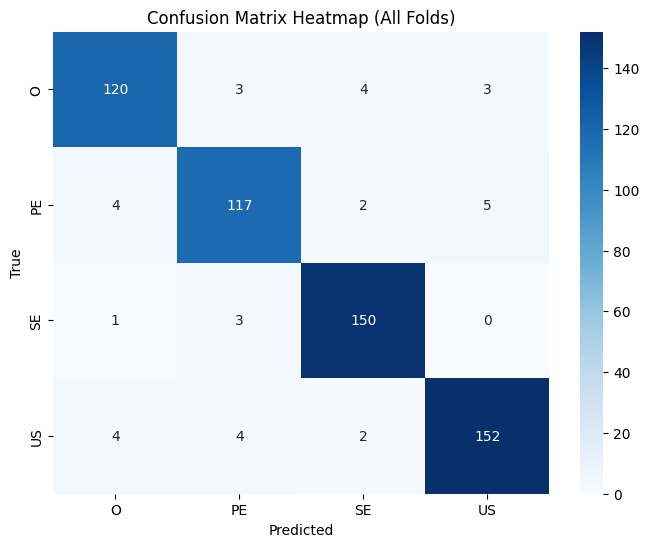

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Gunakan hyperparameter terbaik dari Bayesian Optimization
best_params = study.best_params
print("Hyperparameter Optimal:", best_params)

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

fold_accuracies = []
all_true_labels = []
all_predicted_labels = []

# Loop untuk setiap fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Processing Fold {fold + 1}...")

    # Split data untuk fold ini
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Inisialisasi model
    dbn = DBN([X.shape[1], 128, 64])
    classifier = DBNClassifier(dbn, output_dim=len(torch.unique(y)), dropout_rate=0.5)

    # Pretrain DBN
    train_dbn(dbn, X_train.numpy(), epochs_per_rbm=best_params['epoch_per_rbm'],
              batch_size=best_params['batch_size'], learning_rate=best_params['lr'])

    # Fine-tune DBNClassifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=best_params['lr'])
    for _ in range(best_params['epoch']):
        classifier.train()
        for i in range(0, len(X_train), best_params['batch_size']):
            batch_X = X_train[i:i + best_params['batch_size']]
            batch_y = y_train[i:i + best_params['batch_size']]
            optimizer.zero_grad()
            outputs = classifier(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluasi model pada validation set
    classifier.eval()
    with torch.no_grad():
        y_val_pred = torch.argmax(classifier(X_val), dim=1).numpy()
        fold_accuracy = accuracy_score(y_val.numpy(), y_val_pred)
        fold_accuracies.append(fold_accuracy)

        # Simpan hasil prediksi dan label asli untuk confusion matrix
        all_true_labels.extend(y_val.numpy())
        all_predicted_labels.extend(y_val_pred)

    print(f"Fold {fold + 1} Accuracy: {fold_accuracy:.4f}")

# Rata-rata akurasi
avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f"\nRata-rata Akurasi Cross-Validation: {avg_accuracy:.4f}")

# Evaluasi keseluruhan
print("\nClassification Report (All Folds):")
print(classification_report(all_true_labels, all_predicted_labels, target_names=['O', 'PE', 'SE', 'US']))

# Confusion Matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['O', 'PE', 'SE', 'US'], yticklabels=['O', 'PE', 'SE', 'US'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Heatmap (All Folds)")
plt.show()


In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Processing Fold {fold + 1}...")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    dbn = DBN([X.shape[1], 128, 64])
    classifier = DBNClassifier(dbn, output_dim=len(torch.unique(y)), dropout_rate=0.5)

    train_dbn(dbn, X_train.numpy(), epochs_per_rbm=best_params['epoch_per_rbm'],
              batch_size=best_params['batch_size'], learning_rate=best_params['lr'])

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=best_params['lr'])

    fold_train_losses = []
    fold_val_losses = []
    fold_train_accuracies = []
    fold_val_accuracies = []

    for epoch in range(best_params['epoch']):
        classifier.train()
        epoch_train_loss = 0
        correct_train = 0

        for i in range(0, len(X_train), best_params['batch_size']):
            batch_X = X_train[i:i + best_params['batch_size']]
            batch_y = y_train[i:i + best_params['batch_size']]

            optimizer.zero_grad()
            outputs = classifier(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            correct_train += (torch.argmax(outputs, dim=1) == batch_y).sum().item()

        epoch_train_loss /= len(X_train)
        epoch_train_accuracy = correct_train / len(X_train)
        fold_train_losses.append(epoch_train_loss)
        fold_train_accuracies.append(epoch_train_accuracy)

        classifier.eval()
        epoch_val_loss = 0
        correct_val = 0

        with torch.no_grad():
            for i in range(0, len(X_val), best_params['batch_size']):
                batch_X = X_val[i:i + best_params['batch_size']]
                batch_y = y_val[i:i + best_params['batch_size']]
                outputs = classifier(batch_X)
                loss = criterion(outputs, batch_y)
                epoch_val_loss += loss.item()
                correct_val += (torch.argmax(outputs, dim=1) == batch_y).sum().item()

        epoch_val_loss /= len(X_val)
        epoch_val_accuracy = correct_val / len(X_val)
        fold_val_losses.append(epoch_val_loss)
        fold_val_accuracies.append(epoch_val_accuracy)

        print(f"Epoch {epoch + 1}/{best_params['epoch']} - Train Loss: {epoch_train_loss:.4f}, "
              f"Train Accuracy: {epoch_train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, "
              f"Val Accuracy: {epoch_val_accuracy:.4f}")

    train_losses.append(fold_train_losses)
    val_losses.append(fold_val_losses)
    train_accuracies.append(fold_train_accuracies)
    val_accuracies.append(fold_val_accuracies)

Processing Fold 1...
Epoch 1/19 - Train Loss: 0.0137, Train Accuracy: 0.2829, Val Loss: 0.0232, Val Accuracy: 0.3621
Epoch 2/19 - Train Loss: 0.0131, Train Accuracy: 0.3217, Val Loss: 0.0220, Val Accuracy: 0.5690
Epoch 3/19 - Train Loss: 0.0124, Train Accuracy: 0.4244, Val Loss: 0.0203, Val Accuracy: 0.6724
Epoch 4/19 - Train Loss: 0.0112, Train Accuracy: 0.5543, Val Loss: 0.0179, Val Accuracy: 0.6724
Epoch 5/19 - Train Loss: 0.0098, Train Accuracy: 0.6453, Val Loss: 0.0152, Val Accuracy: 0.7069
Epoch 6/19 - Train Loss: 0.0079, Train Accuracy: 0.7578, Val Loss: 0.0121, Val Accuracy: 0.7586
Epoch 7/19 - Train Loss: 0.0063, Train Accuracy: 0.8333, Val Loss: 0.0096, Val Accuracy: 0.7759
Epoch 8/19 - Train Loss: 0.0049, Train Accuracy: 0.8740, Val Loss: 0.0077, Val Accuracy: 0.8966
Epoch 9/19 - Train Loss: 0.0038, Train Accuracy: 0.9050, Val Loss: 0.0080, Val Accuracy: 0.7759
Epoch 10/19 - Train Loss: 0.0029, Train Accuracy: 0.9225, Val Loss: 0.0059, Val Accuracy: 0.8621
Epoch 11/19 - Trai

In [ ]:
# Rata-rata metrik seluruh fold
avg_train_losses = np.mean(train_losses, axis=0)
avg_val_losses = np.mean(val_losses, axis=0)
avg_train_accuracies = np.mean(train_accuracies, axis=0)
avg_val_accuracies = np.mean(val_accuracies, axis=0)



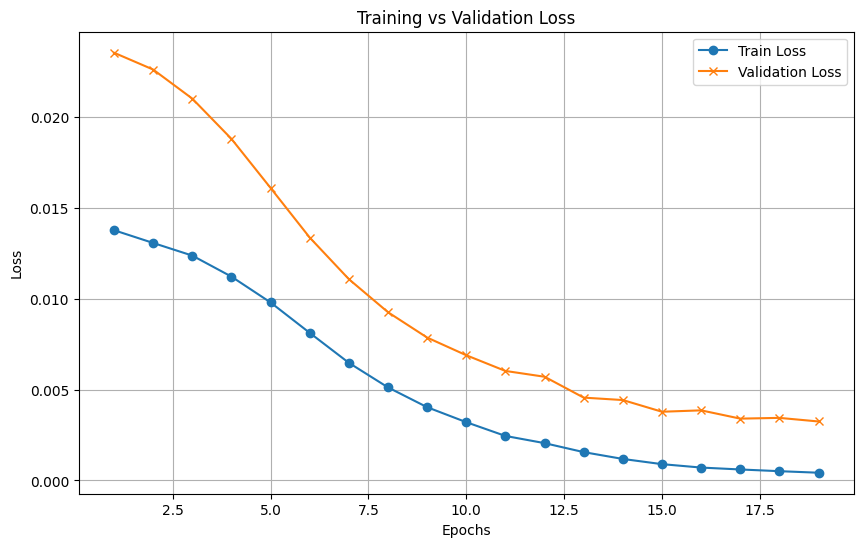

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(avg_train_losses) + 1), avg_train_losses, label="Train Loss", marker='o')
plt.plot(range(1, len(avg_val_losses) + 1), avg_val_losses, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()


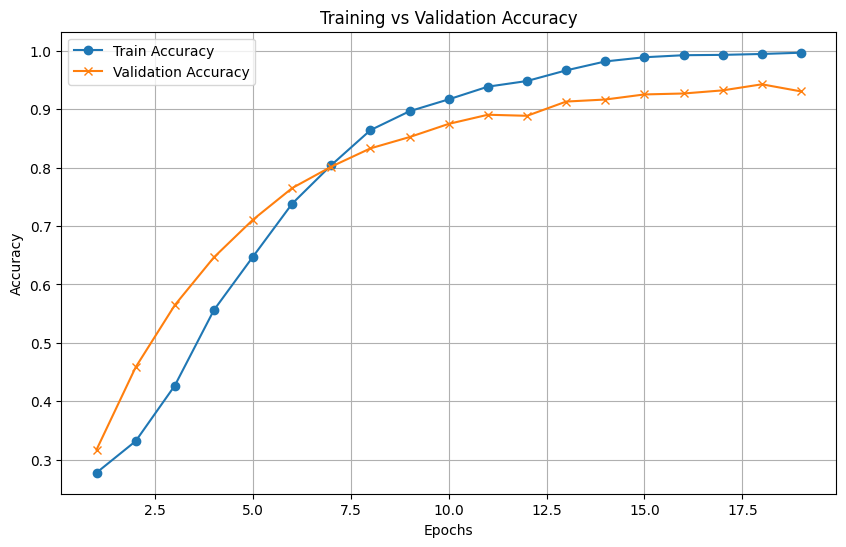

In [ ]:
# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(avg_train_accuracies) + 1), avg_train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, len(avg_val_accuracies) + 1), avg_val_accuracies, label="Validation Accuracy", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(f"Total Data: {len(X)}")
print(f"Training Data: {len(X_train)}")
print(f"Validation Data: {len(X_val)}")

Total Data: 574
Training Data: 517
Validation Data: 57
